In [1]:
import pickle
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
path_images = 'C:\\Users\\Oussama\\Desktop\\TD1_DL\\cifar-10-batches-py\\'

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
def lecture_cifar(path_images):
    dic = unpickle(path_images+'data_batch_1')
    X=np.array(dic[b'data'], dtype='int32')    
    Y=np.array(dic[b'labels'])
    for l in ['data_batch_2','data_batch_3','data_batch_4',
              'data_batch_5', 'test_batch']:
        dic1 = unpickle(path_images+l)
        X1 = np.array(dic1[b'data'], dtype='int32')
        Y1 = np.array(dic1[b'labels'])
        X = np.concatenate((X, X1), axis=0)
        Y= np.concatenate((Y, Y1) ,axis=0)
    
    return X, Y

In [5]:
def decoupage_donnees(X, Y):
    D, N = X.shape
    
    list_index_train = random.sample(range(D-1) , int(D*0.8))
    list_index_test = [l for l in range(D) if l not in list_index_train]
    
    Xapp = X[list_index_train, :]
    Yapp = np.take(Y, list_index_train)
    
    Xtest = X[list_index_test, :]
    Ytest= np.take(Y, list_index_test)
    
    return Xapp, Yapp, Xtest, Ytest

In [6]:
X, Y = lecture_cifar(path_images)
Xapp, Yapp, Xtest, Ytest = decoupage_donnees(X, Y)

In [7]:
print('Training set size: %s' %str(Xapp.shape))
print('Training labels size: %s ' %str(Yapp.shape))
print('Testing set size: %s' %str(Xtest.shape))
print('Testing labels size: %s' %str(Ytest.shape))

Training set size: (48000, 3072)
Training labels size: (48000,) 
Testing set size: (12000, 3072)
Testing labels size: (12000,)


# Partie KNN :

In [8]:
def kppv_distances(Xtest, Xapp):
    m = Xapp.shape[0]
    n = Xtest.shape[0]
    Xapp2 = np.sum(Xapp**2, axis=1).reshape(m,1)
    Xtest2 = np.sum(Xtest**2, axis=1).reshape(1,n)
    XappXtest = Xapp.dot(Xtest.T)
    dists = np.sqrt(Xapp2+Xtest2-2*XappXtest)
    return dists

In [9]:
Dist = kppv_distances(Xtest, Xapp)
print(Dist.shape)

(48000, 12000)


In [10]:
def kppv_predict(Dist, Yapp, K):
    num_test = Dist.shape[1]
    Ypred = []
    for i in range(num_test):        
        indices_voisins_proches = np.argsort(Dist[:,i],axis=0)[:K]
        voisins_proches = Yapp[indices_voisins_proches]
        vote_voisins = Counter(voisins_proches).most_common()
        if len(vote_voisins) == K :
            Ypred.append(voisins_proches[0])
        else :
            Ypred.append(int(vote_voisins[0][0]))
    return Ypred

In [13]:
def evaluation_classifieur(Ytest, Ypred):
    evalu = Ytest==Ypred
    return sum(evalu)/len(evalu)

### Expérimentations : 

1- Influence de nombre de voisins K sur l'efficacité du classifieur

In [15]:
def trace():
    K=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70]
    acc = []
    for k in K :
        Ypred = kppv_predict(Dist, Yapp, k)
        acc.append(evaluation_classifieur(Ytest, Ypred))
    plt.plot(K,acc)
    plt.xlabel('nombre de voisins K')
    plt.ylabel('Taux de classification')
    plt.title("Influence de nombre de voisins K sur l'efficacité du classifieur")

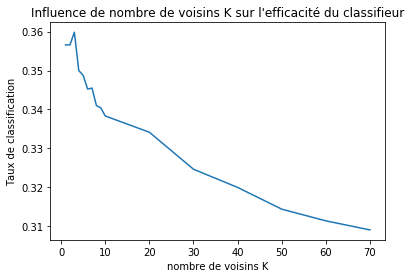

In [16]:
trace()

2- Réprésentation des images par des descripteurs LBP et HOG

In [23]:
#L'image est représentée par 3 matrices 32x32
def img_CIFAR(ind):
    arr = X[ind]
    R = arr[0:1024].reshape(32,32)/255.0
    G = arr[1024:2048].reshape(32,32)/255.0
    B = arr[2048:].reshape(32,32)/255.0
 
    img = np.dstack((R,G,B))
    return img

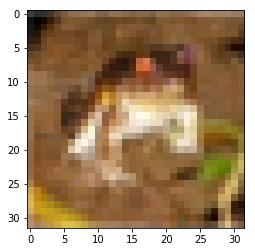

In [24]:
#Exemple : Plot image 0 du dataset
img = img_CIFAR(0)
plt.imshow(img)

In [25]:
#Représentation LBP & HOG
from skimage.feature import hog, local_binary_pattern
from skimage import color

#Transformation d'une image à 3 matrices (R B G) en une matrice grise
img2d = color.rgb2gray(img)

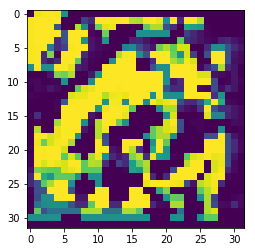

In [26]:
#Image LBD
lbp = local_binary_pattern(img2d, 24, 3)
plt.imshow(lbp)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


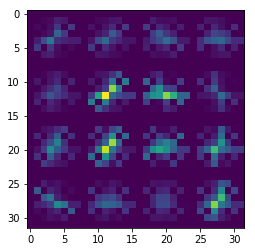

In [27]:
#Image HOG
Hog = hog(img2d, visualize=True)[1]
plt.imshow(Hog)

Maitenant on va essayer d'appliquer KNN sur la représentation LBP et HOG de ces images

In [30]:
#Transformation de X LBP
def Transfor_LBD(X): 
    X_lbd = []
    for i in range(len(X)):
        img = img_CIFAR(i)
        img2d = color.rgb2gray(img)
        lbp = local_binary_pattern(img2d, 24, 3)
        X_lbd.append(list(lbp.reshape((1,1024))[0]))
    return np.array(X_lbd)

In [31]:
X_lbd = Transfor_LBD(X)
Xapp_lbd, Yapp_lbd, Xtest_lbd, Ytest_lbd = decoupage_donnees(X_lbd, Y)
Dist_lbd = kppv_distances(Xtest_lbd, Xapp_lbd)

In [33]:
Ypred_lbd = kppv_predict(Dist_lbd, Yapp_lbd, K=3)
print('accuracy KNN LBD transformation : %s '%(evaluation_classifieur(Ytest_lbd, Ypred_lbd)))

accuracy KNN LBD transformation : 0.293 


# Partie Réseau de neurones

In [35]:
from sklearn import preprocessing

In [36]:
#On normalise les données pour ne pas avoir des warning overfloat avec
#l'exponentiel quand on entraine le RN
X = preprocessing.normalize(X, norm='max', axis=0)

In [37]:
Xapp, Yapp, Xtest, Ytest = decoupage_donnees(X, Y)

In [38]:
print('Training set size: %s' %str(Xapp.shape))
print('Training labels size: %s ' %str(Yapp.shape))
print('Testing set size: %s' %str(Xtest.shape))
print('Testing labels size: %s' %str(Ytest.shape))

Training set size: (48000, 3072)
Training labels size: (48000,) 
Testing set size: (12000, 3072)
Testing labels size: (12000,)


Adaptation du réseau de neurones à 1 couche cachée à CIFAR classification

In [39]:
np.random.seed(1)

N, D_in, D_h, D_out = 60000, 32*32*3, 50, 10
learning_rate = 1e-2
W1 = 2 * np.random.random((D_in, D_h)) - 1
b1 = np.zeros((1,D_h))
W2 = 2 * np.random.random((D_h, D_out)) - 1
b2 = np.zeros((1,D_out))

In [40]:
batch_size=200
num_iters=1000
num_train = Xapp.shape[0]
iterations_per_epoch = max(num_train / batch_size, 1)

In [41]:
loss_history = []
train_acc_history = []

for it in range(num_iters):
    X_batch = None
    y_batch = None
    
    random_minibatch = np.random.choice(np.arange(num_train), batch_size)
    X_batch = Xapp[random_minibatch]
    y_batch = Yapp[random_minibatch]
    
    I1 = X_batch.dot(W1) + b1 # Potentiel d'entrée de la couche cachée
    O1 = 1/(1+np.exp(-I1)) # Sortie de la couche cachée (fonction d'activation de type sigmoïde)
    I2 = O1.dot(W2) + b2 # Potentiel d'entrée de la couche de sortie
    O2 = 1/(1+np.exp(-I2)) # Sortie de la couche de sortie (fonction d'activation de type sigmoïde)
    Y_pred = O2 # Les valeurs prédites sont les sorties de la couche de sortie
    
    
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_batch)
    Y_true = lb.transform(y_batch)
    loss = np.square(Y_pred - Y_true).sum() / len(Y_true)
    loss_history.append(loss)
    
    
    delta_O2 = O2 - Y_true 
    delta_I2 = (1 - O2) * O2 *delta_O2 
    delta_w2 = np.dot(O1.T, delta_I2)
    delta_b2 = np.sum(delta_I2, axis=0)
    delta_O1 = delta_I2.dot(W2.T)
    delta_I1 = delta_O1 * (1 - O1) *O1
    delta_w1 = np.dot(X_batch.T, delta_I1)
    delta_b1 = np.sum(delta_I1, axis=0)
    W2 -= learning_rate * delta_w2
    b2 -= learning_rate * delta_b2
    W1 -= learning_rate * delta_w1
    b1 -= learning_rate * delta_b1
    
    #Accuracy
    y_pred = []
    z1 = Xtest.dot(W1) + b1
    a1 = 1/(1+np.exp(-z1))
    scores = a1.dot(W2) + b2
    y_pred = np.argmax(scores, axis=1)
    train_acc_history.append((y_pred == Ytest).mean())

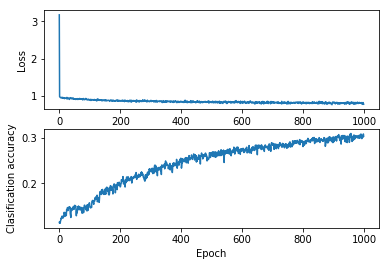

Accuracy sur les données test : 0.30383333333333334


In [42]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel("Nombre d'itérations")
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

print('Accuracy sur les données test : %s'%(train_acc_history[-1]))

### Expérimentations

In [43]:
#Pour la suite on va utiliser des fonctions pour faire les expérimentations

def reseau_neurone_une_couche(D_in, D_h, D_out, Xapp, Yapp, Xtest, Ytest, num_iters, learning_rate, batch_size):
    
    W1 = 2 * np.random.random((D_in, D_h)) - 1
    b1 = np.zeros((1,D_h))
    W2 = 2 * np.random.random((D_h, D_out)) - 1
    b2 = np.zeros((1,D_out))
    
    loss_history = []
    train_acc_history = []

    for it in range(num_iters):
        X_batch = None
        y_batch = None

        random_minibatch = np.random.choice(np.arange(num_train), batch_size)
        X_batch = Xapp[random_minibatch]
        y_batch = Yapp[random_minibatch]

        I1 = X_batch.dot(W1) + b1 # Potentiel d'entrée de la couche cachée
        O1 = 1/(1+np.exp(-I1)) # Sortie de la couche cachée (fonction d'activation de type sigmoïde)
        I2 = O1.dot(W2) + b2 # Potentiel d'entrée de la couche de sortie
        O2 = 1/(1+np.exp(-I2)) # Sortie de la couche de sortie (fonction d'activation de type sigmoïde)
        Y_pred = O2 # Les valeurs prédites sont les sorties de la couche de sortie


        lb = preprocessing.LabelBinarizer()
        lb.fit(y_batch)
        Y_true = lb.transform(y_batch)
        loss = np.square(Y_pred - Y_true).sum() / len(Y_true)
        loss_history.append(loss)


        delta_O2 = O2 - Y_true 
        delta_I2 = (1 - O2) * O2 *delta_O2 
        delta_w2 = np.dot(O1.T, delta_I2)
        delta_b2 = np.sum(delta_I2, axis=0)
        delta_O1 = delta_I2.dot(W2.T)
        delta_I1 = delta_O1 * (1 - O1) *O1
        delta_w1 = np.dot(X_batch.T, delta_I1)
        delta_b1 = np.sum(delta_I1, axis=0)
        W2 -= learning_rate * delta_w2
        b2 -= learning_rate * delta_b2
        W1 -= learning_rate * delta_w1
        b1 -= learning_rate * delta_b1

        #Accuracy
        y_pred = []
        z1 = Xtest.dot(W1) + b1
        a1 = 1/(1+np.exp(-z1))
        scores = a1.dot(W2) + b2
        y_pred = np.argmax(scores, axis=1)
        train_acc_history.append((y_pred == Ytest).mean())
    
    params = {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2}
        
    return params, loss_history, train_acc_history

In [44]:
#Varier le nombre de neurones dans la couche cachée
N, D_in, D_out = 60000, 32*32*3, 10
learning_rate = 1e-2
batch_size=200
num_iters=1000

D_hs = [20,30,40,50,60,80,100]

for D_h in D_hs :
    train_acc_history = reseau_neurone_une_couche(D_in, D_h, D_out, Xapp, Yapp, Xtest, Ytest,
                              num_iters, learning_rate, batch_size)[-1]
    print("Pour %s neurones dans la couche cachée, Accuracy = %s" %(D_h,train_acc_history[-1]))
    

Pour 20 neurones dans la couche cachée, Accuracy = 0.1825
Pour 30 neurones dans la couche cachée, Accuracy = 0.27125
Pour 40 neurones dans la couche cachée, Accuracy = 0.31666666666666665
Pour 50 neurones dans la couche cachée, Accuracy = 0.31683333333333336
Pour 60 neurones dans la couche cachée, Accuracy = 0.31233333333333335
Pour 80 neurones dans la couche cachée, Accuracy = 0.31983333333333336
Pour 100 neurones dans la couche cachée, Accuracy = 0.32758333333333334


In [45]:
#Ajout couche reseau de neurones
def reseau_neurone_deux_couches(D_in, D_h, D_out, Xapp, Yapp, Xtest, Ytest, num_iters, learning_rate, batch_size):
    
    W1 = 2 * np.random.random((D_in, D_h)) - 1
    b1 = np.zeros((1,D_h))
    W2 = 2 * np.random.random((D_h, D_h)) - 1
    b2 = np.zeros((1,D_h))
    W3 = 2 * np.random.random((D_h, D_out)) - 1
    b3 = np.zeros((1,D_out))
    
    loss_history = []
    train_acc_history = []

    for it in range(num_iters):
        X_batch = None
        y_batch = None

        random_minibatch = np.random.choice(np.arange(num_train), batch_size)
        X_batch = Xapp[random_minibatch]
        y_batch = Yapp[random_minibatch]

        I1 = X_batch.dot(W1) + b1 # Potentiel d'entrée de la couche cachée
        O1 = 1/(1+np.exp(-I1)) # Sortie de la couche cachée (fonction d'activation de type sigmoïde)
        I2 = O1.dot(W2) + b2 # Potentiel d'entrée de la couche de sortie
        O2 = 1/(1+np.exp(-I2)) # Sortie de la couche de sortie (fonction d'activation de type sigmoïde)
        I3 = O2.dot(W3) + b3
        O3 = 1/(1+np.exp(-I3)) 
        Y_pred = O3 # Les valeurs prédites sont les sorties de la couche de sortie


        lb = preprocessing.LabelBinarizer()
        lb.fit(y_batch)
        Y_true = lb.transform(y_batch)
        loss = np.square(Y_pred - Y_true).sum() / len(Y_true)
        loss_history.append(loss)


        delta_O3 = O3 - Y_true 
        delta_I3 = (1 - O3) * O3 *delta_O3 
        delta_w3 = np.dot(O2.T, delta_I3)
        delta_b3 = np.sum(delta_I3, axis=0)
        delta_O2 = delta_I3.dot(W3.T)
        delta_I2 = delta_O2 * (1 - O2) *O2
        delta_w2 = np.dot(O1.T, delta_I2)
        delta_b2 = np.sum(delta_I2, axis=0)
        delta_O1 = delta_I2.dot(W2.T)
        delta_I1 = delta_O1 * (1 - O1) *O1
        delta_w1 = np.dot(X_batch.T, delta_I1)
        delta_b1 = np.sum(delta_I1, axis=0)
        W3 -= learning_rate * delta_w3
        b3 -= learning_rate * delta_b3
        W2 -= learning_rate * delta_w2
        b2 -= learning_rate * delta_b2
        W1 -= learning_rate * delta_w1
        b1 -= learning_rate * delta_b1

        #Accuracy
        y_pred = []
        z1 = Xtest.dot(W1) + b1
        a1 = 1/(1+np.exp(-z1))
        z2 = a1.dot(W2) + b2
        a2 = 1/(1+np.exp(-z2))
        scores = a2.dot(W3)+b3
        y_pred = np.argmax(scores, axis=1)
        train_acc_history.append((y_pred == Ytest).mean())
    
    params = {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2, 'W3':W3, 'b3':b3}
        
    return params, loss_history, train_acc_history

Accuracy données test réseau de neurones deux couches : 0.3001666666666667


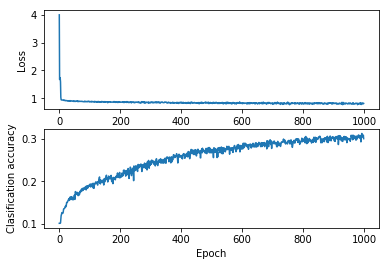

In [46]:
N, D_in, D_h, D_out = 60000, 32*32*3, 50, 10
learning_rate = 1e-2
batch_size=200
num_iters=1000
result = reseau_neurone_deux_couches(D_in, D_h, D_out, Xapp, Yapp, Xtest, Ytest,
                            num_iters, learning_rate, batch_size)
print("Accuracy données test réseau de neurones deux couches : %s" %result[-1][-1])

plt.subplot(2, 1, 1)
plt.plot(result[1])
plt.xlabel("Nombre d'itérations")
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(result[2], label='val')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [47]:
#Réseau de neurones une couche fonction d'activation = ReLu 
#et loss = cross entropy

def ReLU(x):
    return x * (x > 0)

def d_ReLU(x):
    return 1. * (x > 0)

def cross_entropy(predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

def reseau_neurone_une_couche_relu_cross_entropy(D_in, D_h, D_out, Xapp, Yapp,
                                                 Xtest,Ytest, num_iters, 
                                                 learning_rate, 
                                                 batch_size):
    
    W1 = 2 * np.random.random((D_in, D_h)) - 1
    b1 = np.zeros((1,D_h))
    W2 = 2 * np.random.random((D_h, D_out)) - 1
    b2 = np.zeros((1,D_out))
    
    loss_history = []
    train_acc_history = []

    for it in range(num_iters):
        X_batch = None
        y_batch = None

        random_minibatch = np.random.choice(np.arange(num_train), batch_size)
        X_batch = Xapp[random_minibatch]
        y_batch = Yapp[random_minibatch]

        I1 = X_batch.dot(W1) + b1 # Potentiel d'entrée de la couche cachée
        O1 = ReLU(I1) # Sortie de la couche cachée (fonction d'activation de type sigmoïde)
        I2 = O1.dot(W2) + b2 # Potentiel d'entrée de la couche de sortie
        O2 = ReLU(I2) # Sortie de la couche de sortie (fonction d'activation de type sigmoïde)
        Y_pred = O2 # Les valeurs prédites sont les sorties de la couche de sortie


        lb = preprocessing.LabelBinarizer()
        lb.fit(y_batch)
        Y_true = lb.transform(y_batch)
        loss = cross_entropy(Y_pred, Y_true, epsilon=1e-12)
        loss_history.append(loss)


        delta_O2 = O2 - Y_true 
        delta_I2 = d_ReLU(O2) *delta_O2 
        delta_w2 = np.dot(O1.T, delta_I2)
        delta_b2 = np.sum(delta_I2, axis=0)
        delta_O1 = delta_I2.dot(W2.T)
        delta_I1 = delta_O1 * d_ReLU(O1)
        delta_w1 = np.dot(X_batch.T, delta_I1)
        delta_b1 = np.sum(delta_I1, axis=0)
        W2 -= learning_rate * delta_w2
        b2 -= learning_rate * delta_b2
        W1 -= learning_rate * delta_w1
        b1 -= learning_rate * delta_b1

        #Accuracy
        y_pred = []
        z1 = Xtest.dot(W1) + b1
        a1 = np.maximum(0,z1)
        scores = a1.dot(W2) + b2
        y_pred = np.argmax(scores, axis=1)
        train_acc_history.append((y_pred == Ytest).mean())
    
    params = {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2}
        
    return params, loss_history, train_acc_history

Accuracy données test réseau de neurones deux couches : 0.10091666666666667


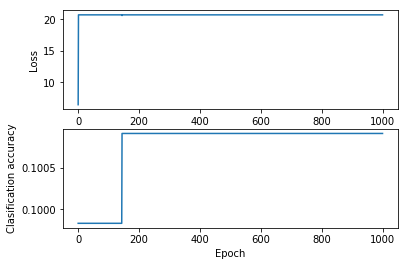

In [48]:
N, D_in, D_h, D_out = 60000, 32*32*3, 50, 10
learning_rate = 1e-4
batch_size=200
num_iters=1000
result = reseau_neurone_une_couche_relu_cross_entropy(D_in, D_h, D_out,
                                                    Xapp, Yapp, Xtest, Ytest,
                                                    num_iters, learning_rate,
                                                    batch_size)
print("Accuracy données test réseau de neurones deux couches : %s" %result[-1][-1])

plt.subplot(2, 1, 1)
plt.plot(result[1])
plt.xlabel("Nombre d'itérations")
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(result[2], label='val')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

Text(0, 0.5, 'Accuracy données test')

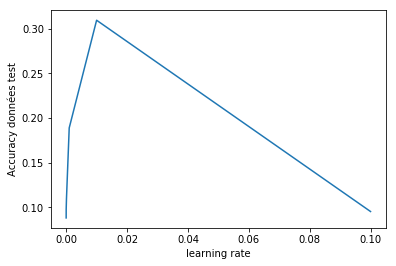

In [49]:
#faire varier le learning rate 
N, D_in, D_h, D_out = 60000, 32*32*3, 50, 10
list_learning_rate = [0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
batch_size=200
num_iters=1000

train_acc_history = []
for learning_rate in list_learning_rate :
    train_acc_history.append(reseau_neurone_une_couche(D_in, D_h, D_out, Xapp, Yapp, Xtest, Ytest,
                              num_iters, learning_rate, batch_size)[-1][-1])

plt.plot(list_learning_rate, train_acc_history)
plt.xlabel('learning rate')
plt.ylabel('Accuracy données test')

Text(0, 0.5, 'Accuracy données test')

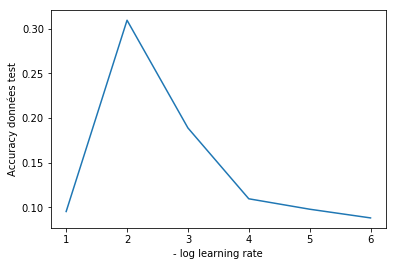

In [50]:
plt.plot(-np.log10(list_learning_rate), train_acc_history)
plt.xlabel('- log learning rate')
plt.ylabel('Accuracy données test')